# Adil HTML Model Creation

## Upload CSV File to Colab Runtime

In [10]:
!wget --no-check-certificate \
      https://storage.googleapis.com/adil-dataset/adil-dataset.csv \
      -O ./data.csv

--2021-05-27 13:14:04--  https://storage.googleapis.com/adil-dataset/adil-dataset.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.62.128, 172.253.115.128, 172.253.122.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.62.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13730505 (13M) [application/octet-stream]
Saving to: ‘./data.csv’

./data.csv          100%[===================>]  13.09M  --.-KB/s    in 0.06s   

2021-05-27 13:14:05 (216 MB/s) - ‘./data.csv’ saved [13730505/13730505]



## Importing Libraries


In [4]:
import tensorflow as tf
import pandas as pd
import sklearn
import csv
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## Prepocessing


In [5]:
vocab_size = 20000
embedding_dim = 16
max_length = 150
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

TEST_SIZE = 0.2
RANDOM_STATE = 42

BUFFER_SIZE = 1000
BATCH_SIZE = 128

contents = []
labels = []

### Open Dataset CSV

In [6]:
with open('data.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        labels.append(row[2])
        contents.append(row[1])

### Split Training and Validation Data

In [7]:
train_contents, test_contents, train_labels, test_labels = train_test_split(contents, labels, test_size=TEST_SIZE, random_state=RANDOM_STATE)

### Tokenization

In [8]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_contents)
word_index = tokenizer.word_index

label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(labels)

print(word_index)

{'<OOV>': 1, 'dan': 2, 'yang': 3, 'pasal': 4, 'dalam': 5, 'dengan': 6, '1': 7, 'ayat': 8, 'atau': 9, '2': 10, 'dimaksud': 11, 'sebagaimana': 12, 'undang': 13, 'pada': 14, 'indonesia': 15, 'untuk': 16, 'daerah': 17, '3': 18, 'negara': 19, 'di': 20, 'oleh': 21, 'republik': 22, 'cukup': 23, 'jelas': 24, 'peraturan': 25, 'tahun': 26, 'dari': 27, 'presiden': 28, 'tidak': 29, 'pemerintah': 30, 'ketentuan': 31, 'kepada': 32, 'dapat': 33, 'a': 34, 'anggota': 35, 'nomor': 36, 'b': 37, 'kota': 38, '4': 39, 'huruf': 40, 'kpu': 41, 'kabupaten': 42, 'paling': 43, 'provinsi': 44, 'tentang': 45, 'adalah': 46, 'pidana': 47, 'pemilu': 48, 'ini': 49, 'calon': 50, 'c': 51, '5': 52, '000': 53, 'sebagai': 54, 'atas': 55, 'dilakukan': 56, 'lain': 57, 'suara': 58, 'melakukan': 59, 'dprd': 60, 'orang': 61, 'secara': 62, 'serta': 63, 'sesuai': 64, 'pelaksanaan': 65, 'negeri': 66, 'hal': 67, 'badan': 68, 'd': 69, 'kepala': 70, 'umum': 71, 'hak': 72, 'hukum': 73, 'menteri': 74, 'setiap': 75, 'tersebut': 76, 'ter

### Pad Sequences

In [9]:
train_sequences = tokenizer.texts_to_sequences(train_contents)
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)

validation_sequences = tokenizer.texts_to_sequences(test_contents)
validation_padded = pad_sequences(validation_sequences, padding=padding_type, maxlen=max_length)

train_label_sequences = np.array(label_tokenizer.texts_to_sequences(train_labels))
validation_label_sequences = np.array(label_tokenizer.texts_to_sequences(test_labels))

print(len(train_sequences))
print(train_padded.shape)

print(len(validation_sequences))
print(validation_padded.shape)

print(len(train_label_sequences))
print(train_label_sequences.shape)

print(len(validation_label_sequences))
print(validation_label_sequences.shape)

78973
(78973, 150)
19744
(19744, 150)
78973
(78973, 1)
19744
(19744, 1)


### Convert to TF Datasets

In [10]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_padded, train_label_sequences))
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

validation_dataset = tf.data.Dataset.from_tensor_slices((validation_padded, validation_label_sequences))
validation_dataset = validation_dataset.batch(BATCH_SIZE)

### Prefetch and Cache the dataset

In [11]:
train_dataset = train_dataset.repeat().prefetch(tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.cache()

## Neural Network Creation



### Network Layers

In [12]:
model = keras.Sequential([
    keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    keras.layers.Conv1D(32, 3, activation='relu'),
    keras.layers.GlobalAveragePooling1D(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(5, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 150, 16)           320000    
_________________________________________________________________
conv1d (Conv1D)              (None, 148, 32)           1568      
_________________________________________________________________
global_average_pooling1d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 128)               4224      
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 645       
Total params: 326,437
Trainable params: 326,437
Non-trainable params: 0
_________________________________________________________________


### Loss Function and Optimizer

In [13]:
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

### Train the model

In [14]:
EPOCHS = 15
steps = tf.math.ceil(len(contents) / BATCH_SIZE)

history = model.fit(train_dataset, epochs=EPOCHS, 
                    validation_data=validation_dataset, 
                    steps_per_epoch=steps)

Epoch 1/15
772/772 [==============================] - 16s 20ms/step - loss: 0.3902 - accuracy: 0.8715 - val_loss: 0.2018 - val_accuracy: 0.9468
Epoch 2/15
772/772 [==============================] - 15s 20ms/step - loss: 0.1259 - accuracy: 0.9717 - val_loss: 0.0728 - val_accuracy: 0.9842
Epoch 3/15
772/772 [==============================] - 15s 20ms/step - loss: 0.0457 - accuracy: 0.9915 - val_loss: 0.0411 - val_accuracy: 0.9915
Epoch 4/15
772/772 [==============================] - 15s 19ms/step - loss: 0.0290 - accuracy: 0.9937 - val_loss: 0.0334 - val_accuracy: 0.9920
Epoch 5/15
772/772 [==============================] - 15s 20ms/step - loss: 0.0211 - accuracy: 0.9947 - val_loss: 0.0298 - val_accuracy: 0.9932
Epoch 6/15
772/772 [==============================] - 15s 20ms/step - loss: 0.0176 - accuracy: 0.9961 - val_loss: 0.0311 - val_accuracy: 0.9944
Epoch 7/15
772/772 [==============================] - 15s 20ms/step - loss: 0.0141 - accuracy: 0.9967 - val_loss: 0.0322 - val_accuracy:

### Visualize Learning History

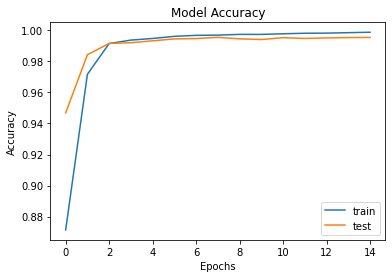

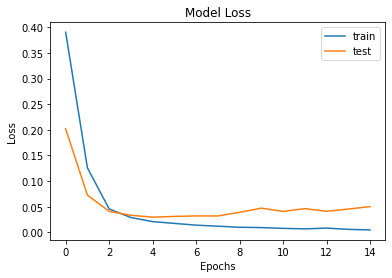

In [15]:
def visualize_history():
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epochs')
  plt.legend(['train', 'test'])
  plt.show()

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epochs')
  plt.legend(['train', 'test'])
  plt.show()

visualize_history()

## Save model to GCP Bucket

In [16]:
!pip install --upgrade google-cloud-storage

Requirement already up-to-date: google-cloud-storage in /usr/local/lib/python3.7/dist-packages (1.38.0)


In [17]:
!mkdir -p saved_model

### Save model to Local Storage

In [18]:
model.save('saved_model/adil_model')

INFO:tensorflow:Assets written to: saved_model/adil_model/assets


In [31]:
!zip -r saved_model/adil_model.zip saved_model/adil_model

  adding: saved_model/adil_model/ (stored 0%)
  adding: saved_model/adil_model/assets/ (stored 0%)
  adding: saved_model/adil_model/saved_model.pb (deflated 87%)
  adding: saved_model/adil_model/keras_metadata.pb (deflated 87%)
  adding: saved_model/adil_model/variables/ (stored 0%)
  adding: saved_model/adil_model/variables/variables.data-00000-of-00001 (deflated 18%)
  adding: saved_model/adil_model/variables/variables.index (deflated 62%)


### Upload Service Account from GCP

In [20]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  service_account = fn
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=service_account, length=len(uploaded[fn])))

Saving adil-gcp-13783a2acc15.json to adil-gcp-13783a2acc15.json
User uploaded file "adil-gcp-13783a2acc15.json" with length 2293 bytes


In [36]:
import os

os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = service_account

In [37]:
!echo $GOOGLE_APPLICATION_CREDENTIALS

adil-gcp-13783a2acc15.json


### Upload Model to Bucket

In [38]:
from google.cloud import storage

def upload_model(bucket_name, source_name, destination_name):
  storage_client = storage.Client()
  bucket = storage_client.bucket(bucket_name)
  blob = bucket.blob(destination_name)

  blob.upload_from_filename(source_name)
  print("File {} uploaded to Bucket: {}, with filename: {}".format(source_name, 
                                                                   bucket_name, 
                                                                   destination_name))

In [40]:
upload_model("adil-model", "saved_model/adil_model.zip", "adil_model.zip")

File saved_model/adil_model.zip uploaded to Bucket: adil-model, with filename: adil_model.zip
